In [1]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset, 
                              DataLoader,
                              TensorDataset)
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'IPAPGothic'
%matplotlib inline

torch.manual_seed(1)    # reproducible
from fastprogress import master_bar, progress_bar

In [2]:
def binary_encode(i, num_digits):
    return np.array([i >> d & 1 for d in range(num_digits)])

def fizz_buzz_encode(i):
    if   i % 15 == 0: return 3
    elif i % 5  == 0: return 2
    elif i % 3  == 0: return 1
    else: return 0

def fizz_buzz(i, prediction):
    return [str(i), "fizz", "buzz", "fizzbuzz"][prediction]


In [3]:
for i in range(1, 10):
    print(binary_encode(i, 10))

[1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0]
[1 0 1 0 0 0 0 0 0 0]
[0 1 1 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0]
[1 0 0 1 0 0 0 0 0 0]


In [4]:
NUM_DIGITS = 10
NUM_HIDDEN = 100
BATCH_SIZE = 128
X = np.array([binary_encode(i, NUM_DIGITS) for i in range(101, 2 ** NUM_DIGITS)])
y = np.array([fizz_buzz_encode(i) for i in range(101, 2 ** NUM_DIGITS)])

In [5]:
X.shape

(923, 10)

In [6]:
X_train = X[100:]
y_train = y[100:]
X_valid = X[:100]
y_valid = y[:100]

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_valid = torch.tensor(y_valid, dtype=torch.int64)

In [8]:
net = nn.Sequential(
    nn.Linear(10, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 4),
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.05)

ds = TensorDataset(X_train, y_train)
loader = DataLoader(ds, batch_size=32, shuffle=True)

In [9]:
train_losses = []
test_losses = []

for _ in progress_bar(range(600)):
    running_loss = 0.0

    net.train()
    
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / i)
    
    net.eval()
    y_pred = net(X_valid)
    test_loss = loss_fn(y_pred, y_valid)
    test_losses.append(test_loss.item())

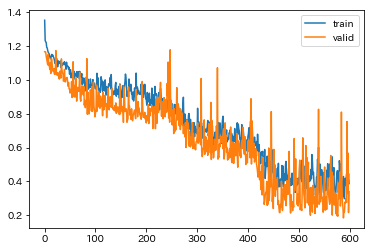

In [10]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='valid')
plt.legend()

In [11]:
numbers = np.arange(1, 101)
X_test = np.array([binary_encode(i, NUM_DIGITS) for i in range(1, 101)])
X_test = torch.tensor(X_test, dtype=torch.float32)

In [12]:
net.eval()
_, y_pred = torch.max(net(X_test), 1)

In [13]:
y_pred

tensor([0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 3, 2, 0, 1, 0, 2, 0, 0, 0, 1,
        2, 0, 1, 0, 0, 3, 0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 0, 0, 0, 0, 3, 0, 0, 1,
        0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 3, 0, 0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 3, 0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 3, 0, 0, 1, 0, 2, 1,
        0, 0, 1, 0])

In [14]:
output = np.vectorize(fizz_buzz)(numbers, y_pred)
output

array(['1', '2', 'fizz', '4', 'buzz', 'fizz', '7', '8', 'fizz', 'buzz',
       '11', 'fizz', '13', '14', 'fizzbuzz', 'buzz', '17', 'fizz', '19',
       'buzz', '21', '22', '23', 'fizz', 'buzz', '26', 'fizz', '28', '29',
       'fizzbuzz', '31', '32', 'fizz', '34', 'buzz', 'fizz', '37', '38',
       'fizz', 'buzz', '41', '42', '43', '44', 'fizzbuzz', '46', '47',
       'fizz', '49', 'buzz', 'fizz', '52', '53', 'fizz', 'buzz', '56',
       'fizz', '58', '59', 'fizzbuzz', '61', '62', 'fizz', '64', 'buzz',
       'fizz', '67', '68', 'fizz', '70', '71', 'fizz', '73', '74',
       'fizzbuzz', '76', '77', 'fizz', '79', 'buzz', 'fizz', '82', '83',
       'fizz', 'buzz', '86', 'fizz', '88', '89', 'fizzbuzz', '91', '92',
       'fizz', '94', 'buzz', 'fizz', '97', '98', 'fizz', '100'],
      dtype='<U8')

In [15]:
y_true = np.array([fizz_buzz_encode(i) for i in range(1, 101)])
y_true

array([0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 3, 0, 0, 1, 0, 2, 1, 0, 0,
       1, 2, 0, 1, 0, 0, 3, 0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 3, 0,
       0, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 3, 0, 0, 1, 0, 2, 1, 0, 0, 1,
       2, 0, 1, 0, 0, 3, 0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 0, 0, 3, 0, 0,
       1, 0, 2, 1, 0, 0, 1, 2])

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.94999999999999996